Riyyan Prediction Code

Starting electricity demand forecasting with 24-hour horizon...
Loading and preprocessing data...
Data shape after preprocessing: (162267, 23)
Preparing features and splitting data...
Training set size: (129813, 17),Test set size: (32454, 17)
Evaluating baseline models...

Baseline Model Results:
Previous Day:
  MAE: 0.0728
  RMSE: 0.1597
  MAPE: 0.1920
Week Average:
  MAE: 0.0825
  RMSE: 0.1895
  MAPE: 0.2192
Training Linear Regression model...
Training Polynomial Regression (degree=2) model...
Training Random Forest model...
Training XGBoost model...
Training Neural Network model feed forward ...
Training ARIMA model...
Training SARIMA model...

Individual Model Results:
Linear Regression:
  MAE: 0.0793
  RMSE: 0.1468
  MAPE: 0.1990
  R²: 0.9821
Polynomial Regression:
  MAE: 0.0808
  RMSE: 0.1415
  MAPE: 0.1930
  R²: 0.9834
Random Forest:
  MAE: 0.0857
  RMSE: 0.1455
  MAPE: 0.2159
  R²: 0.9824
XGBoost:
  MAE: 0.0913
  RMSE: 0.1404
  MAPE: 0.2018
  R²: 0.9837
Neural Network:
  MAE: 0

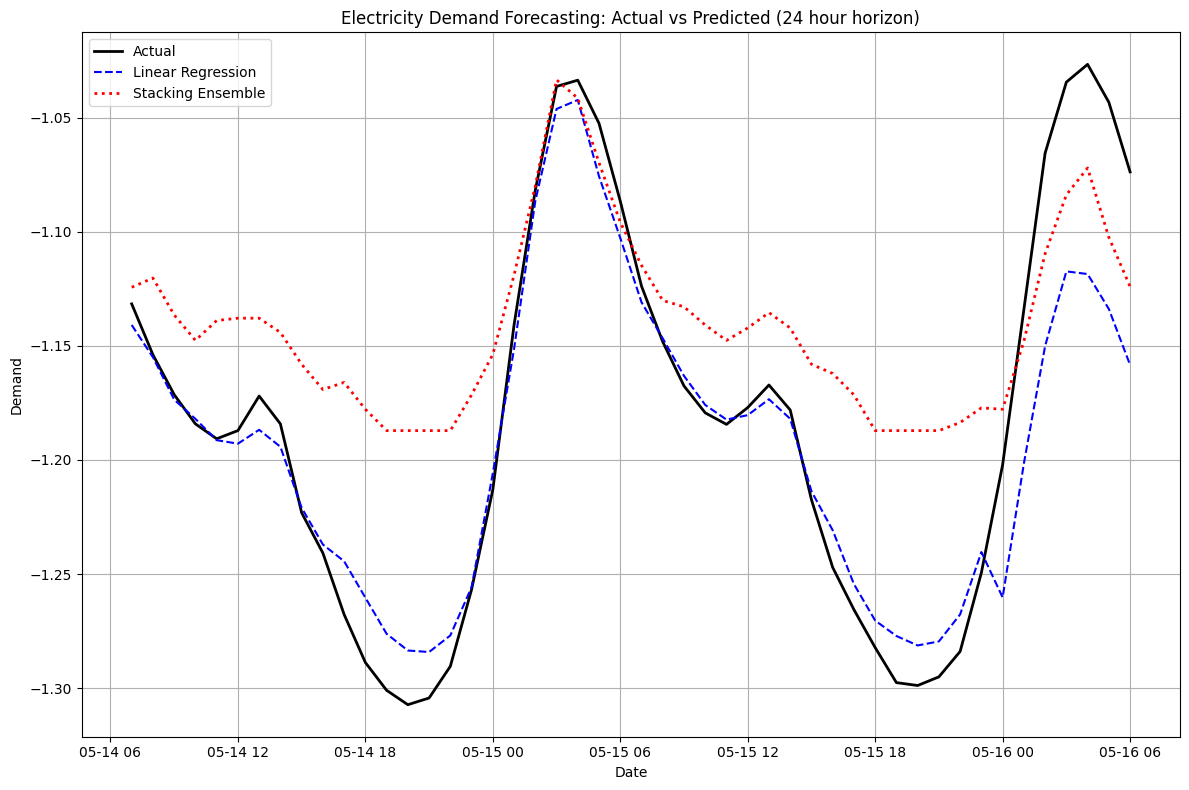

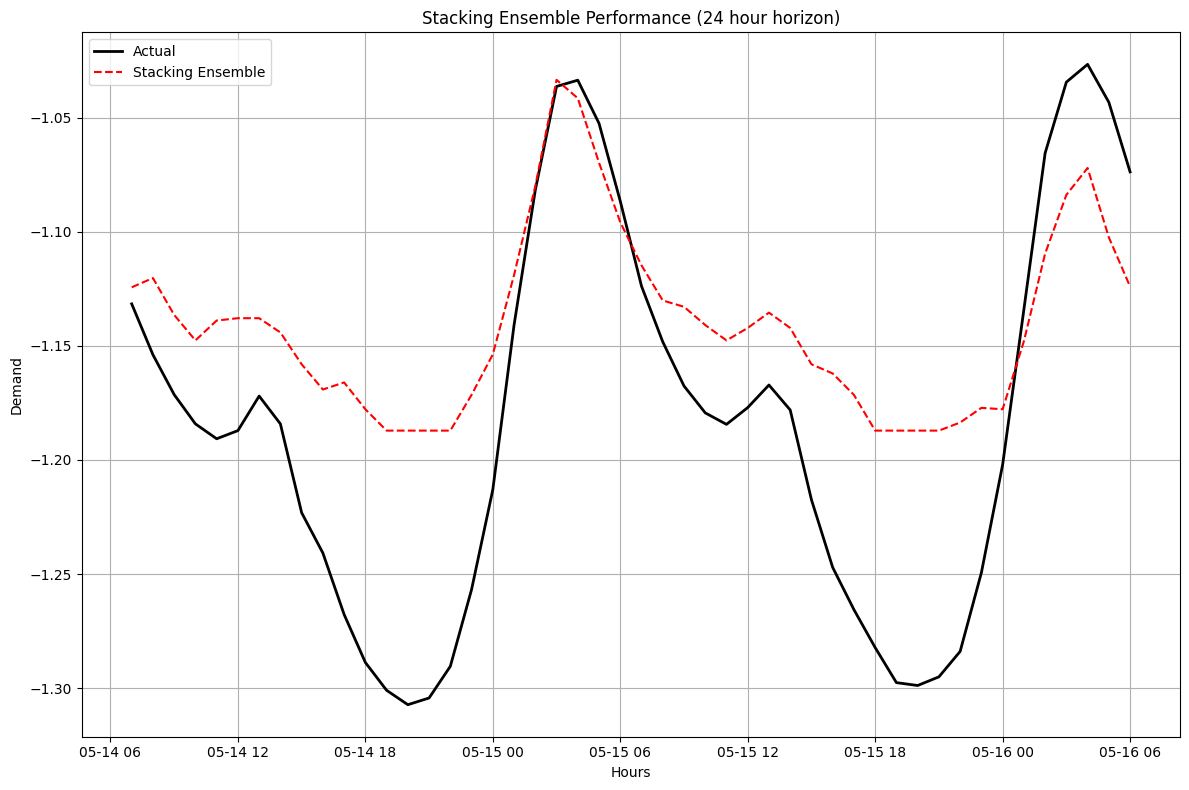

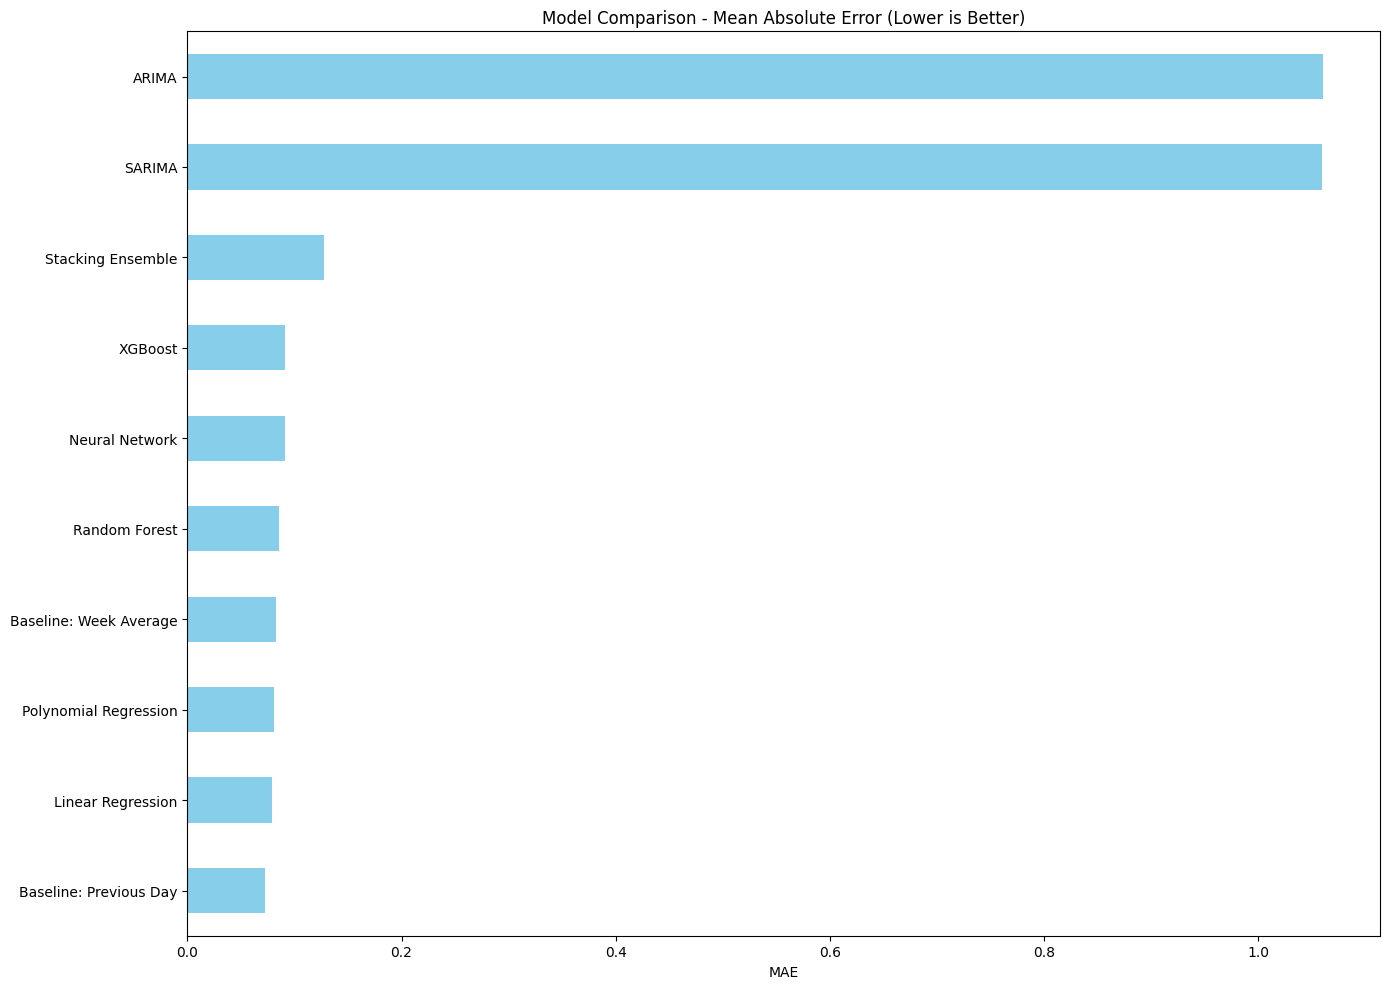


Model Comparison Results (sorted by MAE):
                             MAE      RMSE      MAPE        R2
Baseline: Previous Day  0.072797  0.159651  0.192019       NaN
Linear Regression       0.079328  0.146812  0.199032  0.982122
Polynomial Regression   0.080833  0.141468  0.192992  0.983400
Baseline: Week Average  0.082531  0.189537  0.219202       NaN
Random Forest           0.085663  0.145506  0.215927  0.982439
Neural Network          0.091245  0.140032  0.193561  0.983735
XGBoost                 0.091289  0.140395  0.201829  0.983651
Stacking Ensemble       0.127348  0.173693  0.238576  0.974976
SARIMA                  1.059560  1.422197  2.084800 -0.677705
ARIMA                   1.060718  1.458184  2.140032 -0.763682

Best performing model based on MAE: Baseline: Previous Day
Stacking Ensemble performance rank: 8 out of 10


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor,StackingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

#Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

#Set random seed for reproducibility
np.random.seed(42)

#Define forecasting horizon (in hours)
FORECASTHORIZON=24  #24 hours ahead forecasting

#1. Data Loading and Preprocessing
def loadandpreprocessdata(file_path):
    """
    Load and preprocess the electricity demand data
    """
    print("Loading and preprocessing data...")
    df=pd.read_csv(file_path)
    
    #Convert datetime columns if they exist
    if 'local_time' in df.columns:
        df['local_time']=pd.to_datetime(df['local_time'])
        df.set_index('local_time',inplace=True)
    elif 'date' in df.columns:
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
    
    #Create time-based features
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['month']=df.index.month
    
    #Create seasons based on month
    df['season']=pd.cut(df['month'],
                        bins=[0,3,6,9,12],
                        labels=['Winter','Spring','Summer','Fall'],
                        include_lowest=True)
    
    #Create circular features for time variables
    df['hour_sin']=np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']=np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin']=np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos']=np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin']=np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos']=np.cos(2 * np.pi * df['month'] / 12)
    
    #Create lag features
    df['demand_lag24']=df['demand'].shift(24)  #Previous day,same hour
    df['demand_lag48']=df['demand'].shift(48)  #Two days ago,same hour
    df['demand_lag168']=df['demand'].shift(168)  #One week ago,same hour
    
    #Create rolling window features
    df['demand_rolling_mean24']=df['demand'].rolling(window=24).mean().shift(1)
    
    #One-hot encode categorical features
    df=pd.get_dummies(df,columns=['season'],drop_first=True)
    
    #Is weekend feature
    df['is_weekend']=df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    #Drop rows with missing values (due to lag creation)
    df.dropna(inplace=True)
    
    print(f"Data shape after preprocessing: {df.shape}")
    
    return df

#2. Feature Selection and Split
def prepare_features_and_target(df):
    """
    Create feature sets and split into train/test sets
    """
    print("Preparing features and splitting data...")
    
    #Define features to use
    features=[
        #Weather features (if available)
        'temperature','humidity','windSpeed',
        #Temporal features
        'hour_sin','hour_cos','day_sin','day_cos','month_sin','month_cos','is_weekend',
        #Lag features
        'demand_lag24','demand_lag48','demand_lag168',
        #Rolling statistics
        'demand_rolling_mean24'
    ]
    
    #Add season features if available
    if 'season_Summer' in df.columns:
        features.extend([col for col in df.columns if col.startswith('season_')])
    
    #Make sure all selected features exist in the dataframe
    features=[f for f in features if f in df.columns]
    
    X=df[features]
    y=df['demand']
    
    #Split by date - last 20% for testing (time series aware split)
    splitidx=int(len(df) * 0.8)
    Xtrain,Xtest=X.iloc[:splitidx],X.iloc[splitidx:]
    ytrain,ytest=y.iloc[:splitidx],y.iloc[splitidx:]
    
    #Get the timestamps for plotting
    if isinstance(df.index,pd.DatetimeIndex):
        testdates=df.index[splitidx:]
    else:
        testdates=None
    
    #Scale features for some models
    scaler=StandardScaler()
    Xtrainscaled=scaler.fit_transform(Xtrain)
    Xtestscaled=scaler.transform(Xtest)
    
    print(f"Training set size: {Xtrain.shape},Test set size: {Xtest.shape}")
    
    return Xtrain,Xtest,ytrain,ytest,Xtrainscaled,Xtestscaled,features,testdates

#3. Baseline Models
def baseline_models(Xtest,ytest):
    """
    Create baseline models for comparison
    """
    print("Evaluating baseline models...")
    baselineresults={}
    
    #Previous day's same hour
    ypredprevday=Xtest['demand_lag24']
    
    maeprevday=mean_absolute_error(ytest,ypredprevday)
    rmseprevday=np.sqrt(mean_squared_error(ytest,ypredprevday))
    mapeprevday=mean_absolute_percentage_error(ytest,ypredprevday)
    
    baselineresults['Previous Day']={
        'MAE': maeprevday,
        'RMSE': rmseprevday,
        'MAPE': mapeprevday
    }
    
    #Average of past week same hour (if available)
    if 'demand_lag168' in Xtest.columns:
        pastweekavg=Xtest[['demand_lag24','demand_lag168']].mean(axis=1)
        
        maeweekavg=mean_absolute_error(ytest,pastweekavg)
        rmseweekavg=np.sqrt(mean_squared_error(ytest,pastweekavg))
        mapeweekavg=mean_absolute_percentage_error(ytest,pastweekavg)
        
        baselineresults['Week Average']={
            'MAE': maeweekavg,
            'RMSE': rmseweekavg,
            'MAPE': mapeweekavg
        }
    
    #Print results
    print("\nBaseline Model Results:")
    for modelname,metrics in baselineresults.items():
        print(f"{modelname}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.4f}")
    
    return baselineresults

#4. Train and Evaluate Models
def trainandevaluatemodels(Xtrain,Xtest,ytrain,ytest,Xtrainscaled,Xtestscaled,testdates=None):
    """
    Train and evaluate multiple models
    """
    models={}
    predictions={}
    results={}
    featureimportances={}
    
    #Linear Regression
    print("Training Linear Regression model...")
    lr=LinearRegression()
    lr.fit(Xtrain,ytrain)
    ypredlr=lr.predict(Xtest)
    
    models['Linear Regression']=lr
    predictions['Linear Regression']=ypredlr
    results['Linear Regression']={
        'MAE': mean_absolute_error(ytest,ypredlr),
        'RMSE': np.sqrt(mean_squared_error(ytest,ypredlr)),
        'MAPE': mean_absolute_percentage_error(ytest,ypredlr),
        'R2': r2_score(ytest,ypredlr)
    }
    
    #Polynomial Regression (degree=2)
    print("Training Polynomial Regression (degree=2) model...")
    polypipeline=Pipeline([
        ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
        ('regressor',LinearRegression())
    ])
    polypipeline.fit(Xtrain,ytrain)
    ypredpoly=polypipeline.predict(Xtest)
    
    models['Polynomial Regression']=polypipeline
    predictions['Polynomial Regression']=ypredpoly
    results['Polynomial Regression']={
        'MAE': mean_absolute_error(ytest,ypredpoly),
        'RMSE': np.sqrt(mean_squared_error(ytest,ypredpoly)),
        'MAPE': mean_absolute_percentage_error(ytest,ypredpoly),
        'R2': r2_score(ytest,ypredpoly)
    }
    
    #Random Forest
    print("Training Random Forest model...")
    rf=RandomForestRegressor(n_estimators=100,random_state=42)
    rf.fit(Xtrain,ytrain)
    ypredrf=rf.predict(Xtest)
    
    models['Random Forest']=rf
    predictions['Random Forest']=ypredrf
    results['Random Forest']={
        'MAE': mean_absolute_error(ytest,ypredrf),
        'RMSE': np.sqrt(mean_squared_error(ytest,ypredrf)),
        'MAPE': mean_absolute_percentage_error(ytest,ypredrf),
        'R2': r2_score(ytest,ypredrf)
    }
    featureimportances['Random Forest']=rf.feature_importances_
    
    #XGBoost
    print("Training XGBoost model...")
    xgb=XGBRegressor(n_estimators=100,learning_rate=0.1,random_state=42)
    xgb.fit(Xtrain,ytrain)
    ypredxgb=xgb.predict(Xtest)
    
    models['XGBoost']=xgb
    predictions['XGBoost']=ypredxgb
    results['XGBoost']={
        'MAE': mean_absolute_error(ytest,ypredxgb),
        'RMSE': np.sqrt(mean_squared_error(ytest,ypredxgb)),
        'MAPE': mean_absolute_percentage_error(ytest,ypredxgb),
        'R2': r2_score(ytest,ypredxgb)
    }
    featureimportances['XGBoost']=xgb.feature_importances_
    
    #Neural Network
    print("Training Neural Network model feed forward ...")
    nn=MLPRegressor(hidden_layer_sizes=(64,32),activation='relu',max_iter=1000,random_state=42)
    nn.fit(Xtrainscaled,ytrain)
    yprednn=nn.predict(Xtestscaled)
    
    models['Neural Network']=nn
    predictions['Neural Network']=yprednn
    results['Neural Network']={
        'MAE': mean_absolute_error(ytest,yprednn),
        'RMSE': np.sqrt(mean_squared_error(ytest,yprednn)),
        'MAPE': mean_absolute_percentage_error(ytest,yprednn),
        'R2': r2_score(ytest,yprednn)
    }
    
    #Time Series Models
    if testdates is not None and len(testdates) > 0:
        try:
            print("Training ARIMA model...")
            #Convert train and test to Series with datetime index
            ytraints=pd.Series(ytrain.values,index=ytrain.index)
            
            #Fit ARIMA model
            arimamodel=ARIMA(ytraints,order=(2,1,2))
            arimafit=arimamodel.fit()
            
            #Forecast
            arimapreds=arimafit.forecast(steps=len(ytest))
            
            models['ARIMA']=arimafit
            predictions['ARIMA']=arimapreds
            results['ARIMA']={
                'MAE': mean_absolute_error(ytest,arimapreds),
                'RMSE': np.sqrt(mean_squared_error(ytest,arimapreds)),
                'MAPE': mean_absolute_percentage_error(ytest,arimapreds),
                'R2': r2_score(ytest,arimapreds)
            }
        except Exception as e:
            print(f"ARIMA model error: {e}")
        
        try:
            print("Training SARIMA model...")
            #Use a much smaller subset of training data for SARIMA due to memory constraints
            #Take the last month of data or 720 hours (30 days * 24 hours)
            trainsize=min(len(ytraints),720)
            ytrainsubset=ytraints.iloc[-trainsize:]
            
            #Fit SARIMAX model with reduced dataset and simplified order
            sarima_model=SARIMAX(
                ytrainsubset,
                order=(1,1,1),
                seasonal_order=(1,0,0,24), #Simplified seasonal order
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            sarimafit=sarima_model.fit(disp=False)
            
            #Forecast
            sarimapreds=sarimafit.forecast(steps=len(ytest))
            
            models['SARIMA']=sarimafit
            predictions['SARIMA']=sarimapreds
            results['SARIMA']={
                'MAE': mean_absolute_error(ytest,sarimapreds),
                'RMSE': np.sqrt(mean_squared_error(ytest,sarimapreds)),
                'MAPE': mean_absolute_percentage_error(ytest,sarimapreds),
                'R2': r2_score(ytest,sarimapreds)
            }
        except Exception as e:
            print(f"SARIMA model error: {e}")
            print("Trying alternative SARIMA approach with even smaller dataset...")
            
            try:
                #Try with even smaller dataset and simpler model
                trainsize=min(len(ytraints),240)  #10 days of hourly data
                ytrainsubset=ytraints.iloc[-trainsize:]
                
                sarima_model=SARIMAX(
                    ytrainsubset,
                    order=(1,0,0),
                    seasonal_order=(0,0,0,24),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                sarimafit=sarima_model.fit(disp=False)
                
                sarimapreds=sarimafit.forecast(steps=len(ytest))
                
                models['SARIMA-Simple']=sarimafit
                predictions['SARIMA-Simple']=sarimapreds
                results['SARIMA-Simple']={
                    'MAE': mean_absolute_error(ytest,sarimapreds),
                    'RMSE': np.sqrt(mean_squared_error(ytest,sarimapreds)),
                    'MAPE': mean_absolute_percentage_error(ytest,sarimapreds),
                    'R2': r2_score(ytest,sarimapreds)
                }
            except Exception as e:
                print(f"Alternative SARIMA approach also failed: {e}")
    
    #Print results
    print("\nIndividual Model Results:")
    for modelname,metrics in results.items():
        print(f"{modelname}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.4f}")
        print(f"  R²: {metrics['R2']:.4f}")
    
    return models,predictions,results,featureimportances

#5. Ensemble Model
def trainensemblemodel(Xtrain,Xtest,ytrain,ytest,predictions,models):
    """
    Implement a stacking ensemble learning approach.
    
    Stacking combines multiple base models through a meta-learner
    that is trained to find the optimal combination of the base models.
    """
    print("\nTraining Stacking Ensemble Model...")
    ensembleresults={}
    ensemblepredictions={}
    
    #Create a stacking ensemble
    print("Creating stacking ensemble...")
    
    #First level estimators (base models)
    estimators=[
        ('lr',LinearRegression()),
        ('poly',Pipeline([
            ('poly_features',PolynomialFeatures(degree=2,include_bias=False)),
            ('regressor',LinearRegression())
        ])),
        ('rf',RandomForestRegressor(n_estimators=100,random_state=42)),
        ('xgb',XGBRegressor(n_estimators=100,learning_rate=0.1,random_state=42))
    ]
    
    #Second level estimator (meta-learner)
    finalestimator=GradientBoostingRegressor(n_estimators=100,random_state=42)
    
    #Create and train the stacking ensemble
    stackingreg=StackingRegressor(
        estimators=estimators,
        final_estimator=finalestimator,
        cv=5  #5-fold cross-validation for preventing data leakage
    )
    
    #Train the stacking ensemble
    stackingreg.fit(Xtrain,ytrain)
    stackingpreds=stackingreg.predict(Xtest)
    
    #Store the results
    ensemblepredictions['Stacking Ensemble']=stackingpreds
    ensembleresults['Stacking Ensemble']={
        'MAE': mean_absolute_error(ytest,stackingpreds),
        'RMSE': np.sqrt(mean_squared_error(ytest,stackingpreds)),
        'MAPE': mean_absolute_percentage_error(ytest,stackingpreds),
        'R2': r2_score(ytest,stackingpreds)
    }
    
    #Print ensemble results
    print("\nEnsemble Model Results:")
    for modelname,metrics in ensembleresults.items():
        print(f"{modelname}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.4f}")
        print(f"  R²: {metrics['R2']:.4f}")
    
    return ensembleresults,ensemblepredictions

#6. Visualization Functions
def plotpredictions(ytest,predictions,ensemblepredictions,testdates=None,n_hours=48):
    """
    Plot actual vs predicted values for selected models
    """
    plt.figure(figsize=(12,8))
    
    #Subset for better visualization
    yactual=ytest.iloc[:n_hours]
    
    if testdates is not None and len(testdates) >= n_hours:
        x_axis=testdates[:n_hours]
        plt.xlabel('Date')
    else:
        x_axis=range(len(yactual))
        plt.xlabel('Hours')
    
    #Plot actual values
    plt.plot(x_axis,yactual,label='Actual',linewidth=2,color='black')
    
    #Find top performing model
    individualmodels={k: mean_absolute_error(ytest,v) for k,v in predictions.items() 
                       if k not in ['ARIMA','SARIMA']}
    bestmodel=min(individualmodels.items(),key=lambda x: x[1])[0]
    
    #Find top performing ensemble
    ensemblemodels={k: mean_absolute_error(ytest,v) for k,v in ensemblepredictions.items()}
    bestensemble=min(ensemblemodels.items(),key=lambda x: x[1])[0]
    
    #Plot best individual model
    if bestmodel in predictions:
        plt.plot(x_axis,predictions[bestmodel][:n_hours],
                label=bestmodel,linestyle='--',color='blue')
    
    #Plot best ensemble model
    plt.plot(x_axis,ensemblepredictions[bestensemble][:n_hours],
            label=bestensemble,linestyle=':',color='red',linewidth=2)
    
    plt.title(f'Electricity Demand Forecasting: Actual vs Predicted ({FORECASTHORIZON} hour horizon)')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('predictionscomparison.png')
    plt.close()

    #Create a plot to show the stacking ensemble vs actual values
    plt.figure(figsize=(12,8))
    plt.plot(x_axis,yactual,label='Actual',linewidth=2,color='black')
    
    #Plot ensemble method
    if 'Stacking Ensemble' in ensemblepredictions:
        plt.plot(x_axis,ensemblepredictions['Stacking Ensemble'][:n_hours],
                label='Stacking Ensemble',
                linestyle='--',
                color='red')
    
    plt.title(f'Stacking Ensemble Performance ({FORECASTHORIZON} hour horizon)')
    plt.ylabel('Demand')
    plt.xlabel('Hours')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig('ensembleperformance.png')
    plt.close()

def compareallmodels(baselineresults,individualresults,ensembleresults):
    """
    Create comparison table of all models
    """
    #Combine all results
    allresults={}
    
    #Add baseline results
    for model,metrics in baselineresults.items():
        allresults[f"Baseline: {model}"]=metrics
    
    #Add individual model results
    allresults.update(individualresults)
    
    #Add ensemble results
    allresults.update(ensembleresults)
    
    #Create DataFrame for easy comparison
    resultsdf=pd.DataFrame({
        model: {
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'R2': metrics.get('R2',np.nan)  #Some baselines might not have R2
        }
        for model,metrics in allresults.items()
    }).T
    
    #Sort by MAE
    resultsdf=resultsdf.sort_values('MAE')
    
    #Save to CSV
    resultsdf.to_csv('modelcomparison.csv')
    
    #Also plot the results as a bar chart
    plt.figure(figsize=(14,10))
    resultsdf['MAE'].sort_values().plot(kind='barh',color='skyblue')
    plt.title('Model Comparison - Mean Absolute Error (Lower is Better)')
    plt.xlabel('MAE')
    plt.tight_layout()
    plt.show()
    plt.savefig('modelcomparisonmae.png')
    plt.close()
    
    return resultsdf

#7. Main Function
def main(file_path):
    """
    Main function to execute the forecasting pipeline
    """
    print(f"Starting electricity demand forecasting with {FORECASTHORIZON}-hour horizon...")
    
    #Step 1: Load and preprocess data
    df=loadandpreprocessdata(file_path)
    
    #Step 2: Prepare features and split data
    Xtrain,Xtest,ytrain,ytest,Xtrainscaled,Xtestscaled,features,testdates=prepare_features_and_target(df)
    
    #Step 3: Create baseline models
    baselineresults=baseline_models(Xtest,ytest)
    
    #Step 4: Train and evaluate individual models
    models,predictions,individualresults,featureimportances=trainandevaluatemodels(
        Xtrain,Xtest,ytrain,ytest,Xtrainscaled,Xtestscaled,testdates
    )
    
    #Step 5: Train and evaluate stacking ensemble model
    ensembleresults,ensemblepredictions=trainensemblemodel(
        Xtrain,Xtest,ytrain,ytest,predictions,models
    )
    
    #Step 6: Visualizations
    plotpredictions(ytest,predictions,ensemblepredictions,testdates)
    
    #Step 7: Compare all models
    resultscomparison=compareallmodels(baselineresults,individualresults,ensembleresults)
    print("\nModel Comparison Results (sorted by MAE):")
    print(resultscomparison)
    
    #Output best model
    bestmodel=resultscomparison.sort_values('MAE').index[0]
    print(f"\nBest performing model based on MAE: {bestmodel}")
    
    #Output ensemble model performance
    if 'Stacking Ensemble' in resultscomparison.index:
        ensemblerank=resultscomparison.index.get_loc('Stacking Ensemble') + 1
        print(f"Stacking Ensemble performance rank: {ensemblerank} out of {len(resultscomparison)}")
    
    return resultscomparison

if __name__ == "__main__":
    #Replace with your CSV file path
    file_path="scaleddataset.csv"
    main(file_path)

BEEJAY Prediction Code

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

# Load Dataset
df=pd.read_csv("scaleddataset.csv")

# Preprocess
df['local_time']=pd.to_datetime(df['local_time'])
df=df.sort_values("local_time")

# Encode categorical features
df=pd.get_dummies(df,columns=["city","season"],drop_first=True)

# Features and Target
features=['temperature','humidity','windSpeed','hour','dayofweek','month'] + \
           [col for col in df.columns if 'city_' in col or 'season_' in col]
target='demand'

# Split
Xtrain,Xtest,ytrain,ytest=train_test_split(df[features],df[target],test_size=0.2,shuffle=False)

# ----------- Linear Regression -------------
linreg=LinearRegression()
linreg.fit(Xtrain,ytrain)
ypredlr=linreg.predict(Xtest)

# ----------- Polynomial Regression (Degree 2) -------------
poly=PolynomialFeatures(degree=2)
Xtrainpoly=poly.fit_transform(Xtrain)
Xtestpoly=poly.transform(Xtest)
polyreg=LinearRegression()
polyreg.fit(Xtrainpoly,ytrain)
ypredpoly=polyreg.predict(Xtestpoly)

# ----------- Random Forest -------------
rf=RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(Xtrain,ytrain)
ypredrf=rf.predict(Xtest)

# ----------- XGBoost -------------
xgb=XGBRegressor(objective='reg:squarederror')
xgb.fit(Xtrain,ytrain)
ypredxgb=xgb.predict(Xtest)

# ----------- Feedforward ANN -------------
modelann=Sequential([
    Dense(64,activation='relu',input_shape=(Xtrain.shape[1],)),
    Dense(32,activation='relu'),
    Dense(1)
])
modelann.compile(optimizer='adam',loss='mse')
modelann.fit(Xtrain,ytrain,epochs=50,verbose=0)
ypredann=modelann.predict(Xtest).flatten()


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# ----------- LSTM -------------
# Ensure LSTM input format: [samples,timesteps,features]
Xlstm=df[features].astype('float32').values.reshape((df.shape[0],1,len(features)))
ylstm=df[target].astype('float32').values

# Use last 24 hours for testing
Xtrainlstm,Xtestlstm=Xlstm[:-24],Xlstm[-24:]
ytrainlstm,ytestlstm=ylstm[:-24],ylstm[-24:]

# Define and train LSTM model
modellstm=Sequential([
    LSTM(50,activation='relu',input_shape=(1,len(features))),
    Dense(1)
])
modellstm.compile(optimizer='adam',loss='mse')
modellstm.fit(Xtrainlstm,ytrainlstm,epochs=10,verbose=0)

# Predict with LSTM
ypredlstm=modellstm.predict(Xtestlstm).flatten()

# ----------- ARIMA -------------
# Use a smaller window for faster training
arimaseries=df['demand'][-7*24:]  # Last 7 days
arimamodel=ARIMA(arimaseries,order=(5,1,0))
arimafit=arimamodel.fit()
ypredarima=arimafit.forecast(steps=24)

# ----------- SARIMA -------------
# Use a small recent subset of data to avoid memory issues
sarimaseries=df['demand'][-3*24:]  # Last 3 days

sarimamodel=SARIMAX(sarimaseries,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,24),
                       simple_differencing=True)
sarimafit=sarimamodel.fit(disp=False,low_memory=True)
ypredsarima=sarimafit.forecast(steps=24)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step



----- Linear Regression -----
MAE: 0.2104216904480016
RMSE: 0.30455647228223387

----- Polynomial Regression -----
MAE: 0.1915278273709263
RMSE: 0.29239465877658577

----- Random Forest -----
MAE: 0.12950965833787811
RMSE: 0.25245750747141193

----- XGBoost -----
MAE: 0.13341240555999068
RMSE: 0.2475014126564051

----- Feedforward ANN -----
MAE: 0.14106799637676584
RMSE: 0.26231249447464733

----- LSTM -----
MAE: 0.15229862928390503
RMSE: 0.19173646196844998

----- ARIMA -----
MAE: 0.7974881979002065
RMSE: 0.82872877715263

----- SARIMA -----
MAE: 1.5345128026691093
RMSE: 1.8181838874849436


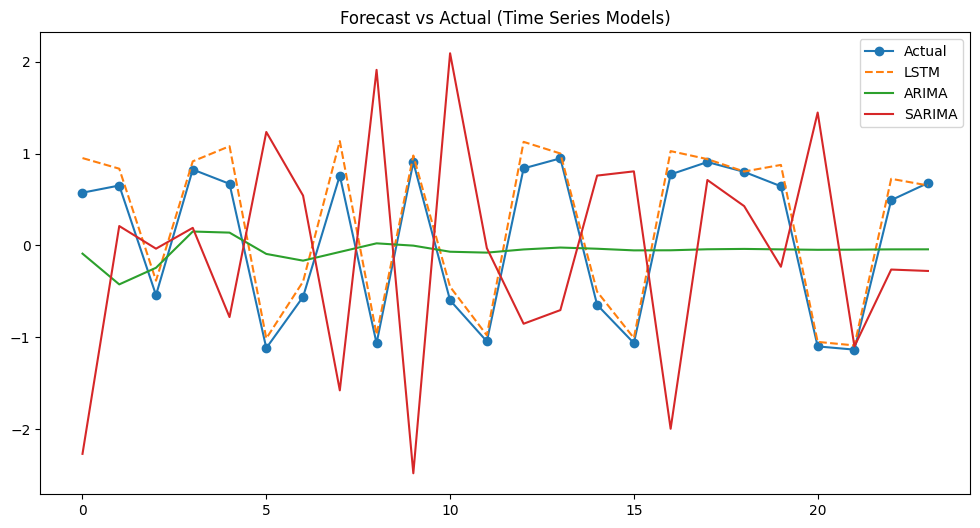

In [6]:
# ----------- Evaluation Function -------------
def evaluate(ytrue,ypred,model_name):
    print(f"\n----- {model_name} -----")
    print("MAE:",mean_absolute_error(ytrue,ypred))
    print("RMSE:",np.sqrt(mean_squared_error(ytrue,ypred)))

evaluate(ytest,ypredlr,"Linear Regression")
evaluate(ytest,ypredpoly,"Polynomial Regression")
evaluate(ytest,ypredrf,"Random Forest")
evaluate(ytest,ypredxgb,"XGBoost")
evaluate(ytest,ypredann,"Feedforward ANN")
evaluate(ytestlstm,ypredlstm,"LSTM")
evaluate(ytestlstm,ypredarima,"ARIMA")
evaluate(ytestlstm,ypredsarima,"SARIMA")

# ----------- Plot Comparison -------------
plt.figure(figsize=(12,6))
plt.plot(range(len(ytestlstm)),ytestlstm,label='Actual',marker='o')
plt.plot(range(len(ytestlstm)),ypredlstm,label='LSTM',linestyle='--')
plt.plot(range(len(ytestlstm)),ypredarima,label='ARIMA')
plt.plot(range(len(ytestlstm)),ypredsarima,label='SARIMA')
plt.legend()
plt.title("Forecast vs Actual (Time Series Models)")
plt.show()